In [1]:
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import datetime
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from matplotlib import pyplot as plt
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.layers import Masking
from keras.layers import Bidirectional, GlobalMaxPool1D
from tqdm import tqdm_notebook
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import RandomOverSampler
from keras.utils import to_categorical
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5243418316899603202
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 480687900724463353
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11342217734406463662
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5811535872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4805602584206424032
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:65:00.0, compute capability: 7.5"
]


In [4]:
!pip install bayesian-optimization

### data 불러오기

In [5]:
Y_가전제품 = pd.read_csv('Y_가전제품.csv')
Y_화장품 = pd.read_csv('Y_화장품.csv')
Y_패션 = pd.read_csv('Y_패션.csv')

In [6]:
Y_가전제품= Y_가전제품['가전제품구매']
Y_화장품= Y_화장품['화장품구매']
Y_패션= Y_패션['패션구매']

In [7]:
X_가전제품 = pd.read_csv('가전제품_3d_array.csv')
X_화장품 = pd.read_csv('화장품_3d_array.csv')
X_패션 = pd.read_csv('패션_3d_array.csv')

In [8]:
Y_가전제품.value_counts()

0    877
2     88
1     50
3     48
Name: 가전제품구매, dtype: int64

In [9]:
X_가전제품.head()

,0,1,2,3,4,5,6,7,8,9,...,94990,94991,94992,94993,94994,94995,94996,94997,94998,94999
0,1754,29010,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,308,10185,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,24,314,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1302,29956,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,1361,7985,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [10]:
X_가전제품 = np.asarray(X_가전제품)
X_화장품 = np.asarray(X_화장품)
X_패션 = np.asarray(X_패션)

### Oversampling

In [11]:
X_가전제품.shape

(1063, 95000)

In [12]:
smote = SMOTE()

In [13]:
#5000일때 자꾸 커널이 죽음
def oversample(X, Y):
    max_len = 5000
    X_resampled, Y_resampled = smote.fit_resample(X, Y)
    X_resampled = X_resampled.reshape(X_resampled.shape[0], max_len, int(X_resampled.shape[1]/max_len))
    return X_resampled, Y_resampled

In [14]:
X_가전제품_resampled, Y_가전제품_resampled =oversample(X_가전제품, Y_가전제품)
X_패션_resampled, Y_패션_resampled = oversample(X_패션, Y_패션)
X_화장품_resampled, Y_화장품_resampled = oversample(X_화장품, Y_화장품)

### LSTM 가동

In [95]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### 패션

In [108]:
X_train.shape

(1606, 5000, 19)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(
X_패션_resampled, Y_패션_resampled, test_size=0.3, random_state=42)

In [106]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [112]:
#masking layer 추가(https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs)
def get_model(input_shape):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(64,input_shape = input_shape))
    #model.add(GlobalMaxPool1D())
    model.add(Dense(32, activation= 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation= 'relu'))
    model.add(Dense(4, activation='sigmoid'))

    return model


In [ ]:
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc'])
    print(model.summary())

#### Bayesian Optimization

In [131]:
def fit_with(input_shape, verbose, lr):

    # Create the model using a specified hyperparameters.
    model = get_model(input_shape)

    # Train the model for a specified number of epochs.
    optimizer = RMSprop(learning_rate=lr)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Train the model with the train dataset.
    model.fit(x=X_train,y= y_train ,epochs=1,
              batch_size=64, verbose=verbose)

    # Evaluate the model with the eval dataset.
    score = model.evaluate(X_test,y= y_test ,steps=10, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # Return the accuracy.

    return score[1]
from functools import partial
input_shape = (X_train.shape[1], X_train.shape[2])
verbose = 1
fit_with_partial = partial(fit_with, input_shape, verbose)

In [132]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'lr': (1e-4, 1e-2)}

optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)


for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

print(optimizer.max)

|   iter    |  target   |    lr     |
-------------------------------------
Epoch 1/1
1606/1606 [==============================] - 116s 72ms/step - loss: 1.2703 - accuracy: 0.3767
Test loss: 0.10801259279251099
Test accuracy: 4.716981053352356
|  1        |  4.717    |  0.004229 |
Epoch 1/1
1606/1606 [==============================] - 118s 73ms/step - loss: 1.0698 - accuracy: 0.4284
Test loss: 0.10224945545196533
Test accuracy: 4.296081364154816
|  2        |  4.296    |  0.007231 |
Epoch 1/1
1606/1606 [==============================] - 125s 78ms/step - loss: 1.4472 - accuracy: 0.2416
Test loss: 0.14132689237594603
Test accuracy: 3.294629752635956
|  3        |  3.295    |  0.000101 |
Epoch 1/1
1606/1606 [==============================] - 118s 73ms/step - loss: 1.1305 - accuracy: 0.4732
Test loss: 0.09361357092857361
Test accuracy: 5.703918933868408
|  4        |  5.704    |  0.003093 |
Epoch 1/1
1606/1606 [==============================] - 118s 73ms/step - loss: 1.1579 - accuracy: 0.3

In [134]:
#masking layer 추가(https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs)
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64,input_shape = (X_train.shape[1], X_train.shape[2])))
#model.add(Glob)
model.add(Dense(32, activation= 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(4, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr= 0.003, rho = 0.9), metrics=['acc'])
print(model.summary())

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_39 (Masking)         (None, 5000, 19)          0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 64)                21504     
_________________________________________________________________
dense_109 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_110 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_111 (Dense)            (None, 4)                 68        
Total params: 24,180
Trainable params: 24,180
Non-trainable params: 0
_________________________________________________________________
None


In [135]:
history = model.fit(X_train, y_train, epochs=30, batch_size=100, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 1606 samples, validate on 689 samples
Epoch 1/30
 - 89s - loss: 1.1655 - acc: 0.4776 - val_loss: 0.9793 - val_acc: 0.5544
Epoch 2/30
 - 86s - loss: 0.9319 - acc: 0.5367 - val_loss: 0.9106 - val_acc: 0.5530
Epoch 3/30
 - 84s - loss: 0.8801 - acc: 0.5411 - val_loss: 0.8682 - val_acc: 0.5559
Epoch 4/30
 - 84s - loss: 0.8536 - acc: 0.5641 - val_loss: 0.8536 - val_acc: 0.5820
Epoch 5/30
 - 85s - loss: 0.8376 - acc: 0.5685 - val_loss: 0.8441 - val_acc: 0.6009
Epoch 6/30
 - 84s - loss: 0.8714 - acc: 0.5585 - val_loss: 0.8209 - val_acc: 0.6023
Epoch 7/30
 - 84s - loss: 0.8212 - acc: 0.5722 - val_loss: 0.8203 - val_acc: 0.6038
Epoch 8/30
 - 85s - loss: 0.8188 - acc: 0.5697 - val_loss: 0.8215 - val_acc: 0.6067
Epoch 9/30
 - 85s - loss: 0.8119 - acc: 0.5685 - val_loss: 0.8360 - val_acc: 0.5922
Epoch 10/30
 - 85s - loss: 0.8087 - acc: 0.5716 - val_loss: 0.8292 - val_acc: 0.6009
Epoch 11/30
 - 82s - loss: 0.8017 - acc: 0.5766 - val_loss: 0.8456 - val_acc: 0.5965
Epoch 12/30
 - 84s - loss: 

In [136]:
X_train.shape

(1606, 5000, 19)

#### feature importance

In [137]:
train_df = pd.DataFrame(X_train.reshape(1606*5000, 19))
train_df.columns = ['세션당 방문사이트수','세션지속시간','쇼핑사이트방문여부' ,
                    '게임', '경제/재테크', '교육/학교', '기타', '뉴스/미디어', '문화/예술', '비즈니스/쇼핑', '생활/건강', '스포츠/레저',
 '여행/세계정보', '연예/오락', '인물', '정치/사회', '종교', '컴퓨터/인터넷', '학문/사전']
## Sensitivity Analysis
importance_df = pd.DataFrame(np.zeros((19, 2)), columns=['varible_name', 'perturbation_effect'])
def var_importance(model):
    x = X_test # Get a sample of data
    orig_out = model.predict(x)
    for i in range(19):  # iterate over the three features
        new_x = x.copy()
        perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5 #RMSE
        importance_df.iloc[i,0] = train_df.columns[i]
        importance_df.iloc[i,1] = effect
        #print(f'Variable {i+1}, perturbation effect: {effect:.4f}')
var_importance(model)
importance_df = importance_df.sort_values(by='perturbation_effect', ascending=False)
print(importance_df)

   varible_name  perturbation_effect
17      컴퓨터/인터넷             0.105500
6            기타             0.067070
9       비즈니스/쇼핑             0.064833
0    세션당 방문사이트수             0.037320
7        뉴스/미디어             0.025902
1        세션지속시간             0.016763
8         문화/예술             0.014035
3            게임             0.005174
11       스포츠/레저             0.005075
15        정치/사회             0.002527
10        생활/건강             0.002033
2     쇼핑사이트방문여부             0.001977
5         교육/학교             0.001861
4        경제/재테크             0.001658
13        연예/오락             0.000948
18        학문/사전             0.000616
14           인물             0.000532
12      여행/세계정보             0.000301
16           종교             0.000023


In [138]:
#perm = PermutationImportance(model, random_state=1).fit(X_test,y_test)
#eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [139]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

In [140]:
#가전제품 f1-score: 0.7819220343082984
#패션 accuracy: 0.7188029361269287

print(accuracy)

0.6023222208023071


#### 가전제품

In [141]:
X_train, X_test, y_train, y_test = train_test_split(
X_가전제품_resampled, Y_가전제품_resampled, test_size=0.3, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [144]:
#쇼핑사이트 방문횟수, 문화/예술, 비즈니스/쇼핑

In [145]:
#masking layer 추가(https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs)
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64,input_shape = (X_train.shape[1], X_train.shape[2])))
#model.add(Glob)
model.add(Dense(32, activation= 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(4, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc'])
print(model.summary())

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_41 (Masking)         (None, 5000, 19)          0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 64)                21504     
_________________________________________________________________
dense_112 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_113 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_114 (Dense)            (None, 4)                 68        
Total params: 24,180
Trainable params: 24,180
Non-trainable params: 0
_________________________________________________________________
None


In [146]:
history = model.fit(X_train, y_train, epochs=30, batch_size=200, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 2455 samples, validate on 1053 samples
Epoch 1/50
 - 38s - loss: 1.3801 - acc: 0.2684 - val_loss: 1.3589 - val_acc: 0.3628
Epoch 2/50
 - 37s - loss: 1.3469 - acc: 0.4012 - val_loss: 1.3279 - val_acc: 0.4520
Epoch 3/50
 - 36s - loss: 1.3215 - acc: 0.4224 - val_loss: 1.2981 - val_acc: 0.4587
Epoch 4/50
 - 36s - loss: 1.2964 - acc: 0.4456 - val_loss: 1.2744 - val_acc: 0.4653
Epoch 5/50
 - 36s - loss: 1.2615 - acc: 0.4648 - val_loss: 1.2259 - val_acc: 0.4995
Epoch 6/50
 - 36s - loss: 1.2211 - acc: 0.4900 - val_loss: 1.1845 - val_acc: 0.5043
Epoch 7/50
 - 36s - loss: 1.1796 - acc: 0.4982 - val_loss: 1.1478 - val_acc: 0.4938
Epoch 8/50
 - 36s - loss: 1.1479 - acc: 0.4941 - val_loss: 1.1309 - val_acc: 0.5062
Epoch 9/50
 - 36s - loss: 1.1204 - acc: 0.5173 - val_loss: 1.0910 - val_acc: 0.5347
Epoch 10/50
 - 36s - loss: 1.0916 - acc: 0.5271 - val_loss: 1.0662 - val_acc: 0.5537
Epoch 11/50
 - 36s - loss: 1.0716 - acc: 0.5397 - val_loss: 1.0472 - val_acc: 0.5698
Epoch 12/50
 - 36s - loss:

In [147]:
X_train.shape

(2455, 5000, 19)

#### feature importance

In [148]:
train_df = pd.DataFrame(X_train.reshape(X_train.shape[0] * X_train.shape[1], 19))
train_df.columns = ['세션당 방문사이트수','세션지속시간','쇼핑사이트방문여부' ,
                    '게임', '경제/재테크', '교육/학교', '기타', '뉴스/미디어', '문화/예술', '비즈니스/쇼핑', '생활/건강', '스포츠/레저',
 '여행/세계정보', '연예/오락', '인물', '정치/사회', '종교', '컴퓨터/인터넷', '학문/사전']

## Sensitivity Analysis
importance_df = pd.DataFrame(np.zeros((19, 2)), columns=['varible_name', 'perturbation_effect'])
def var_importance(model):
    x = X_test # Get a sample of data
    orig_out = model.predict(x)
    for i in range(19):  # iterate over the three features
        new_x = x.copy()
        perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5 #RMSE
        importance_df.iloc[i,0] = train_df.columns[i]
        importance_df.iloc[i,1] = effect
        #print(f'Variable {i+1}, perturbation effect: {effect:.4f}')
var_importance(model)
importance_df = importance_df.sort_values(by='perturbation_effect', ascending=False)
print(importance_df)

   varible_name  perturbation_effect
6            기타             0.019017
0    세션당 방문사이트수             0.018900
9       비즈니스/쇼핑             0.017860
17      컴퓨터/인터넷             0.011322
1        세션지속시간             0.005882
3            게임             0.004853
2     쇼핑사이트방문여부             0.002543
7        뉴스/미디어             0.002450
15        정치/사회             0.002309
5         교육/학교             0.001170
4        경제/재테크             0.000860
16           종교             0.000262
11       스포츠/레저             0.000238
10        생활/건강             0.000212
12      여행/세계정보             0.000210
18        학문/사전             0.000137
13        연예/오락             0.000118
8         문화/예술             0.000115
14           인물             0.000049


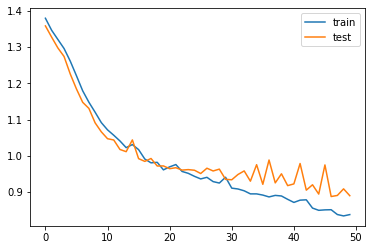

In [149]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()                                       
plt.show()                       

In [150]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

In [151]:
print(accuracy)

0.632478654384613


#### 화장품

In [152]:
X_train, X_test, y_train, y_test = train_test_split(
X_화장품_resampled, Y_화장품_resampled, test_size=0.3, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [153]:
#masking layer 추가(https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs)
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64,input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dense(32, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(4, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc'])
print(model.summary())

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_42 (Masking)         (None, 5000, 19)          0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 64)                21504     
_________________________________________________________________
dense_115 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_32 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_116 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_117 (Dense)            (None, 4)                 68        
Total params: 24,180
Trainable params: 24,180
Non-trainable params: 0
_________________________________________________

In [154]:
history = model.fit(X_train, y_train, epochs=60, batch_size=500, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 1732 samples, validate on 743 samples
Epoch 1/60
 - 28s - loss: 1.4262 - acc: 0.1940 - val_loss: 1.3567 - val_acc: 0.3782
Epoch 2/60
 - 27s - loss: 1.3487 - acc: 0.3597 - val_loss: 1.3113 - val_acc: 0.3432
Epoch 3/60
 - 27s - loss: 1.3087 - acc: 0.3886 - val_loss: 1.2749 - val_acc: 0.4065
Epoch 4/60
 - 27s - loss: 1.2751 - acc: 0.4203 - val_loss: 1.2483 - val_acc: 0.4509
Epoch 5/60
 - 27s - loss: 1.2504 - acc: 0.4434 - val_loss: 1.2251 - val_acc: 0.4711
Epoch 6/60
 - 27s - loss: 1.2308 - acc: 0.4567 - val_loss: 1.2054 - val_acc: 0.4764
Epoch 7/60
 - 27s - loss: 1.2090 - acc: 0.4521 - val_loss: 1.1852 - val_acc: 0.4778
Epoch 8/60
 - 27s - loss: 1.1909 - acc: 0.4544 - val_loss: 1.1623 - val_acc: 0.4926
Epoch 9/60
 - 27s - loss: 1.1592 - acc: 0.4769 - val_loss: 1.1369 - val_acc: 0.5034
Epoch 10/60
 - 26s - loss: 1.1455 - acc: 0.4630 - val_loss: 1.1173 - val_acc: 0.5128
Epoch 11/60
 - 27s - loss: 1.1214 - acc: 0.4902 - val_loss: 1.0938 - val_acc: 0.5168
Epoch 12/60
 - 27s - loss: 

In [155]:
train_df = pd.DataFrame(X_train.reshape(X_train.shape[0] * X_train.shape[1], 19))
train_df.columns = ['세션당 방문사이트수','세션지속시간','쇼핑사이트방문여부' ,
                    '게임', '경제/재테크', '교육/학교', '기타', '뉴스/미디어', '문화/예술', '비즈니스/쇼핑', '생활/건강', '스포츠/레저',
 '여행/세계정보', '연예/오락', '인물', '정치/사회', '종교', '컴퓨터/인터넷', '학문/사전']
## Sensitivity Analysis
importance_df = pd.DataFrame(np.zeros((19, 2)), columns=['varible_name', 'perturbation_effect'])
def var_importance(model):
    x = X_test # Get a sample of data
    orig_out = model.predict(x)
    for i in range(19):  # iterate over the three features
        new_x = x.copy()
        perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5 #RMSE
        importance_df.iloc[i,0] = train_df.columns[i]
        importance_df.iloc[i,1] = effect
        #print(f'Variable {i+1}, perturbation effect: {effect:.4f}')
var_importance(model)
importance_df = importance_df.sort_values(by='perturbation_effect', ascending=False)
print(importance_df)

   varible_name  perturbation_effect
17      컴퓨터/인터넷             0.049682
9       비즈니스/쇼핑             0.042533
6            기타             0.042316
0    세션당 방문사이트수             0.039831
2     쇼핑사이트방문여부             0.024230
8         문화/예술             0.018970
3            게임             0.016526
14           인물             0.007616
7        뉴스/미디어             0.006994
1        세션지속시간             0.005104
15        정치/사회             0.002732
18        학문/사전             0.001604
4        경제/재테크             0.000867
5         교육/학교             0.000790
10        생활/건강             0.000526
11       스포츠/레저             0.000358
13        연예/오락             0.000333
12      여행/세계정보             0.000140
16           종교             0.000001


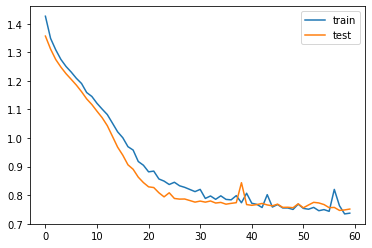

In [156]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()                                       
plt.show()       